In [1]:
!pip install tqdm
# !pip install optuna
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [2]:
# Importing relevant packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

from project1_model import ResNet, BasicBlock


In [3]:
# fetching device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# parameters
num_workers = 10
batch_size = 128
learningRate = 0.3
weight_decay = 0.0001
res_blocks = [3,3]
num_res_layer = len(res_blocks)
kernel=(3,1)
skip_kernel=(3,1)
channels = 128

#### Mean and Standard Deviation for Cifar Dataset -

Mean: tensor([0.4914, 0.4822, 0.4465])

Standard deviation: tensor([0.2471, 0.2435, 0.2616])

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(degrees=(90)),
        transforms.RandomCrop(32, padding=4),
        #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2471, 0.2435, 0.2616]),
#         transforms.RandomErasing(),

    ]),
    'val': transforms.Compose([
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2471, 0.2435, 0.2616])
    ]),
}


dataloaders = {}
for phase in ['train','val']:
    dataset = datasets.CIFAR10(root='./data', train=(phase=='train'),download=True, transform=data_transforms[phase])
    dataloaders[phase] = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=(phase=='train'), num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = ResNet(BasicBlock, channels, num_res_layer, res_blocks,kernel=kernel,skip_kernel=skip_kernel)
model = model.to(device)

In [6]:
LossFunc = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weight_decay)

save_loss = {'train':[], 'val':[]}
save_acc = {'train':[], 'val':[]}

In [7]:
from torchsummary import summary
print(summary(model, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,584
       BatchNorm2d-2          [-1, 128, 32, 32]             256
            Conv2d-3          [-1, 128, 32, 32]         147,584
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]         147,584
       BatchNorm2d-6          [-1, 128, 32, 32]             256
        BasicBlock-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
       BatchNorm2d-9          [-1, 128, 32, 32]             256
           Conv2d-10          [-1, 128, 32, 32]         147,584
      BatchNorm2d-11          [-1, 128, 32, 32]             256
       BasicBlock-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]         147,584
      BatchNorm2d-14          [-1, 128,

In [8]:
for epoch in tqdm(range(200)):
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        current_loss = 0.0
        current_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase], 1):
            inputs,labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Time to carry out the forward training poss
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = LossFunc(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # We want variables to hold the loss/acc statistics
            current_loss += loss.item() * inputs.size(0)
            current_corrects += torch.sum(preds == labels.data)
        # saving variable for plottin
        save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
        save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]
        print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0 -- Phase:train -- Loss:1.45 -- Acc:46.57


  0%|          | 1/200 [00:52<2:53:07, 52.20s/it]

Epoch:0 -- Phase:val -- Loss:2.09 -- Acc:42.03
Epoch:1 -- Phase:train -- Loss:0.96 -- Acc:65.64


  1%|          | 2/200 [01:44<2:52:44, 52.35s/it]

Epoch:1 -- Phase:val -- Loss:1.94 -- Acc:49.96
Epoch:2 -- Phase:train -- Loss:0.77 -- Acc:73.06


  2%|▏         | 3/200 [02:37<2:52:14, 52.46s/it]

Epoch:2 -- Phase:val -- Loss:1.59 -- Acc:56.25
Epoch:3 -- Phase:train -- Loss:0.65 -- Acc:77.23


  2%|▏         | 4/200 [03:30<2:52:27, 52.80s/it]

Epoch:3 -- Phase:val -- Loss:0.97 -- Acc:68.98
Epoch:4 -- Phase:train -- Loss:0.56 -- Acc:80.60


  2%|▎         | 5/200 [04:24<2:53:08, 53.28s/it]

Epoch:4 -- Phase:val -- Loss:0.87 -- Acc:71.16
Epoch:5 -- Phase:train -- Loss:0.50 -- Acc:82.59


  3%|▎         | 6/200 [05:19<2:53:27, 53.65s/it]

Epoch:5 -- Phase:val -- Loss:1.75 -- Acc:61.12
Epoch:6 -- Phase:train -- Loss:0.45 -- Acc:84.40


  4%|▎         | 7/200 [06:12<2:52:21, 53.58s/it]

Epoch:6 -- Phase:val -- Loss:1.25 -- Acc:66.07
Epoch:7 -- Phase:train -- Loss:0.42 -- Acc:85.65


  4%|▍         | 8/200 [07:06<2:52:10, 53.80s/it]

Epoch:7 -- Phase:val -- Loss:1.38 -- Acc:64.25
Epoch:8 -- Phase:train -- Loss:0.38 -- Acc:86.88


  4%|▍         | 9/200 [08:01<2:51:53, 54.00s/it]

Epoch:8 -- Phase:val -- Loss:0.55 -- Acc:81.13
Epoch:9 -- Phase:train -- Loss:0.35 -- Acc:87.75


  5%|▌         | 10/200 [08:54<2:50:45, 53.92s/it]

Epoch:9 -- Phase:val -- Loss:0.51 -- Acc:83.94
Epoch:10 -- Phase:train -- Loss:0.32 -- Acc:88.76


  6%|▌         | 11/200 [09:47<2:48:58, 53.64s/it]

Epoch:10 -- Phase:val -- Loss:1.29 -- Acc:69.75
Epoch:11 -- Phase:train -- Loss:0.30 -- Acc:89.66


  6%|▌         | 12/200 [10:40<2:47:19, 53.40s/it]

Epoch:11 -- Phase:val -- Loss:0.70 -- Acc:79.36
Epoch:12 -- Phase:train -- Loss:0.28 -- Acc:90.23


  6%|▋         | 13/200 [11:33<2:45:50, 53.21s/it]

Epoch:12 -- Phase:val -- Loss:0.74 -- Acc:78.54
Epoch:13 -- Phase:train -- Loss:0.27 -- Acc:90.79


  7%|▋         | 14/200 [12:26<2:44:36, 53.10s/it]

Epoch:13 -- Phase:val -- Loss:0.81 -- Acc:77.79
Epoch:14 -- Phase:train -- Loss:0.25 -- Acc:91.46


  8%|▊         | 15/200 [13:19<2:43:35, 53.06s/it]

Epoch:14 -- Phase:val -- Loss:0.59 -- Acc:82.26
Epoch:15 -- Phase:train -- Loss:0.23 -- Acc:91.94


  8%|▊         | 16/200 [14:12<2:42:40, 53.05s/it]

Epoch:15 -- Phase:val -- Loss:0.59 -- Acc:83.04
Epoch:16 -- Phase:train -- Loss:0.22 -- Acc:92.37


  8%|▊         | 17/200 [15:05<2:41:36, 52.99s/it]

Epoch:16 -- Phase:val -- Loss:0.71 -- Acc:81.78
Epoch:17 -- Phase:train -- Loss:0.21 -- Acc:92.88


  9%|▉         | 18/200 [15:58<2:40:46, 53.00s/it]

Epoch:17 -- Phase:val -- Loss:0.73 -- Acc:80.54
Epoch:18 -- Phase:train -- Loss:0.19 -- Acc:93.18


 10%|▉         | 19/200 [16:51<2:39:39, 52.93s/it]

Epoch:18 -- Phase:val -- Loss:0.58 -- Acc:84.02
Epoch:19 -- Phase:train -- Loss:0.18 -- Acc:93.70


 10%|█         | 20/200 [17:45<2:39:59, 53.33s/it]

Epoch:19 -- Phase:val -- Loss:0.75 -- Acc:81.58
Epoch:20 -- Phase:train -- Loss:0.17 -- Acc:93.98


 10%|█         | 21/200 [18:39<2:40:03, 53.65s/it]

Epoch:20 -- Phase:val -- Loss:0.58 -- Acc:83.15
Epoch:21 -- Phase:train -- Loss:0.16 -- Acc:94.49


 11%|█         | 22/200 [19:33<2:39:23, 53.73s/it]

Epoch:21 -- Phase:val -- Loss:0.67 -- Acc:83.03
Epoch:22 -- Phase:train -- Loss:0.15 -- Acc:94.73


 12%|█▏        | 23/200 [20:28<2:39:06, 53.93s/it]

Epoch:22 -- Phase:val -- Loss:0.52 -- Acc:85.81
Epoch:23 -- Phase:train -- Loss:0.14 -- Acc:95.12


 12%|█▏        | 24/200 [21:22<2:38:45, 54.12s/it]

Epoch:23 -- Phase:val -- Loss:0.50 -- Acc:86.56
Epoch:24 -- Phase:train -- Loss:0.14 -- Acc:95.27


 12%|█▎        | 25/200 [22:17<2:38:28, 54.34s/it]

Epoch:24 -- Phase:val -- Loss:0.80 -- Acc:79.82
Epoch:25 -- Phase:train -- Loss:0.13 -- Acc:95.56


 13%|█▎        | 26/200 [23:11<2:37:38, 54.36s/it]

Epoch:25 -- Phase:val -- Loss:0.52 -- Acc:86.01
Epoch:26 -- Phase:train -- Loss:0.12 -- Acc:95.93


 14%|█▎        | 27/200 [24:06<2:37:07, 54.49s/it]

Epoch:26 -- Phase:val -- Loss:0.60 -- Acc:83.97
Epoch:27 -- Phase:train -- Loss:0.12 -- Acc:95.89


 14%|█▍        | 28/200 [25:01<2:36:11, 54.49s/it]

Epoch:27 -- Phase:val -- Loss:0.36 -- Acc:89.82
Epoch:28 -- Phase:train -- Loss:0.10 -- Acc:96.34


 14%|█▍        | 29/200 [25:55<2:35:28, 54.55s/it]

Epoch:28 -- Phase:val -- Loss:0.50 -- Acc:86.58
Epoch:29 -- Phase:train -- Loss:0.10 -- Acc:96.34


 15%|█▌        | 30/200 [26:50<2:34:36, 54.57s/it]

Epoch:29 -- Phase:val -- Loss:0.66 -- Acc:84.87
Epoch:30 -- Phase:train -- Loss:0.10 -- Acc:96.43


 16%|█▌        | 31/200 [27:45<2:33:48, 54.61s/it]

Epoch:30 -- Phase:val -- Loss:0.72 -- Acc:83.95
Epoch:31 -- Phase:train -- Loss:0.09 -- Acc:96.88


 16%|█▌        | 32/200 [28:39<2:32:55, 54.61s/it]

Epoch:31 -- Phase:val -- Loss:0.63 -- Acc:85.83
Epoch:32 -- Phase:train -- Loss:0.09 -- Acc:96.92


 16%|█▋        | 33/200 [29:34<2:32:01, 54.62s/it]

Epoch:32 -- Phase:val -- Loss:0.54 -- Acc:86.63
Epoch:33 -- Phase:train -- Loss:0.08 -- Acc:97.08


 17%|█▋        | 34/200 [30:28<2:31:05, 54.61s/it]

Epoch:33 -- Phase:val -- Loss:0.41 -- Acc:89.82
Epoch:34 -- Phase:train -- Loss:0.08 -- Acc:97.40


 18%|█▊        | 35/200 [31:23<2:30:11, 54.62s/it]

Epoch:34 -- Phase:val -- Loss:0.60 -- Acc:86.99
Epoch:35 -- Phase:train -- Loss:0.07 -- Acc:97.40


 18%|█▊        | 36/200 [32:18<2:29:21, 54.64s/it]

Epoch:35 -- Phase:val -- Loss:0.75 -- Acc:83.46
Epoch:36 -- Phase:train -- Loss:0.07 -- Acc:97.47


 18%|█▊        | 37/200 [33:12<2:28:24, 54.63s/it]

Epoch:36 -- Phase:val -- Loss:0.58 -- Acc:86.72
Epoch:37 -- Phase:train -- Loss:0.07 -- Acc:97.74


 19%|█▉        | 38/200 [34:07<2:27:28, 54.62s/it]

Epoch:37 -- Phase:val -- Loss:0.73 -- Acc:85.46
Epoch:38 -- Phase:train -- Loss:0.07 -- Acc:97.67


 20%|█▉        | 39/200 [35:02<2:26:35, 54.63s/it]

Epoch:38 -- Phase:val -- Loss:0.61 -- Acc:86.64
Epoch:39 -- Phase:train -- Loss:0.06 -- Acc:97.83


 20%|██        | 40/200 [35:56<2:25:40, 54.63s/it]

Epoch:39 -- Phase:val -- Loss:0.82 -- Acc:83.70
Epoch:40 -- Phase:train -- Loss:0.06 -- Acc:97.92


 20%|██        | 41/200 [36:51<2:24:50, 54.66s/it]

Epoch:40 -- Phase:val -- Loss:0.57 -- Acc:87.89
Epoch:41 -- Phase:train -- Loss:0.06 -- Acc:97.93


 21%|██        | 42/200 [37:46<2:23:49, 54.62s/it]

Epoch:41 -- Phase:val -- Loss:0.49 -- Acc:88.89
Epoch:42 -- Phase:train -- Loss:0.06 -- Acc:98.07


 22%|██▏       | 43/200 [38:40<2:22:52, 54.60s/it]

Epoch:42 -- Phase:val -- Loss:0.45 -- Acc:88.96
Epoch:43 -- Phase:train -- Loss:0.05 -- Acc:98.16


 22%|██▏       | 44/200 [39:35<2:21:55, 54.59s/it]

Epoch:43 -- Phase:val -- Loss:0.92 -- Acc:82.94
Epoch:44 -- Phase:train -- Loss:0.05 -- Acc:98.16


 22%|██▎       | 45/200 [40:29<2:21:04, 54.61s/it]

Epoch:44 -- Phase:val -- Loss:0.67 -- Acc:84.53
Epoch:45 -- Phase:train -- Loss:0.05 -- Acc:98.34


 23%|██▎       | 46/200 [41:24<2:20:11, 54.62s/it]

Epoch:45 -- Phase:val -- Loss:0.46 -- Acc:89.32
Epoch:46 -- Phase:train -- Loss:0.05 -- Acc:98.45


 24%|██▎       | 47/200 [42:19<2:19:20, 54.64s/it]

Epoch:46 -- Phase:val -- Loss:0.80 -- Acc:84.88
Epoch:47 -- Phase:train -- Loss:0.05 -- Acc:98.21


 24%|██▍       | 48/200 [43:13<2:18:27, 54.65s/it]

Epoch:47 -- Phase:val -- Loss:0.54 -- Acc:87.62
Epoch:48 -- Phase:train -- Loss:0.04 -- Acc:98.52


 24%|██▍       | 49/200 [44:08<2:17:27, 54.62s/it]

Epoch:48 -- Phase:val -- Loss:0.40 -- Acc:90.60
Epoch:49 -- Phase:train -- Loss:0.05 -- Acc:98.44


 25%|██▌       | 50/200 [45:03<2:16:36, 54.64s/it]

Epoch:49 -- Phase:val -- Loss:0.46 -- Acc:89.82
Epoch:50 -- Phase:train -- Loss:0.04 -- Acc:98.45


 26%|██▌       | 51/200 [45:57<2:15:36, 54.61s/it]

Epoch:50 -- Phase:val -- Loss:0.56 -- Acc:88.36
Epoch:51 -- Phase:train -- Loss:0.04 -- Acc:98.53


 26%|██▌       | 52/200 [46:52<2:14:42, 54.61s/it]

Epoch:51 -- Phase:val -- Loss:0.44 -- Acc:89.91
Epoch:52 -- Phase:train -- Loss:0.04 -- Acc:98.70


 26%|██▋       | 53/200 [47:46<2:13:48, 54.62s/it]

Epoch:52 -- Phase:val -- Loss:0.76 -- Acc:85.56
Epoch:53 -- Phase:train -- Loss:0.04 -- Acc:98.55


 27%|██▋       | 54/200 [48:41<2:12:51, 54.60s/it]

Epoch:53 -- Phase:val -- Loss:0.46 -- Acc:89.41
Epoch:54 -- Phase:train -- Loss:0.04 -- Acc:98.74


 28%|██▊       | 55/200 [49:36<2:11:58, 54.61s/it]

Epoch:54 -- Phase:val -- Loss:0.46 -- Acc:89.78
Epoch:55 -- Phase:train -- Loss:0.03 -- Acc:98.91


 28%|██▊       | 56/200 [50:30<2:11:04, 54.61s/it]

Epoch:55 -- Phase:val -- Loss:0.46 -- Acc:89.77
Epoch:56 -- Phase:train -- Loss:0.04 -- Acc:98.78


 28%|██▊       | 57/200 [51:25<2:10:11, 54.62s/it]

Epoch:56 -- Phase:val -- Loss:0.74 -- Acc:85.42
Epoch:57 -- Phase:train -- Loss:0.04 -- Acc:98.64


 29%|██▉       | 58/200 [52:19<2:09:09, 54.58s/it]

Epoch:57 -- Phase:val -- Loss:0.77 -- Acc:84.28
Epoch:58 -- Phase:train -- Loss:0.04 -- Acc:98.65


 30%|██▉       | 59/200 [53:14<2:08:22, 54.63s/it]

Epoch:58 -- Phase:val -- Loss:0.49 -- Acc:89.71
Epoch:59 -- Phase:train -- Loss:0.03 -- Acc:98.96


 30%|███       | 60/200 [54:09<2:07:27, 54.63s/it]

Epoch:59 -- Phase:val -- Loss:0.52 -- Acc:88.60
Epoch:60 -- Phase:train -- Loss:0.04 -- Acc:98.77


 30%|███       | 61/200 [55:03<2:06:32, 54.62s/it]

Epoch:60 -- Phase:val -- Loss:0.50 -- Acc:89.35
Epoch:61 -- Phase:train -- Loss:0.03 -- Acc:98.85


 31%|███       | 62/200 [55:58<2:05:36, 54.61s/it]

Epoch:61 -- Phase:val -- Loss:0.50 -- Acc:89.06
Epoch:62 -- Phase:train -- Loss:0.03 -- Acc:98.95


 32%|███▏      | 63/200 [56:52<2:04:41, 54.61s/it]

Epoch:62 -- Phase:val -- Loss:0.50 -- Acc:90.16
Epoch:63 -- Phase:train -- Loss:0.03 -- Acc:98.88


 32%|███▏      | 64/200 [57:47<2:03:48, 54.62s/it]

Epoch:63 -- Phase:val -- Loss:0.43 -- Acc:89.91
Epoch:64 -- Phase:train -- Loss:0.03 -- Acc:98.95


 32%|███▎      | 65/200 [58:42<2:02:55, 54.63s/it]

Epoch:64 -- Phase:val -- Loss:0.49 -- Acc:89.20
Epoch:65 -- Phase:train -- Loss:0.03 -- Acc:98.97


 33%|███▎      | 66/200 [59:36<2:01:56, 54.60s/it]

Epoch:65 -- Phase:val -- Loss:0.55 -- Acc:89.25
Epoch:66 -- Phase:train -- Loss:0.03 -- Acc:98.91


 34%|███▎      | 67/200 [1:00:31<2:01:01, 54.60s/it]

Epoch:66 -- Phase:val -- Loss:0.77 -- Acc:85.61
Epoch:67 -- Phase:train -- Loss:0.03 -- Acc:98.92


 34%|███▍      | 68/200 [1:01:25<2:00:03, 54.57s/it]

Epoch:67 -- Phase:val -- Loss:0.44 -- Acc:90.11
Epoch:68 -- Phase:train -- Loss:0.03 -- Acc:99.02


 34%|███▍      | 69/200 [1:02:20<1:59:15, 54.62s/it]

Epoch:68 -- Phase:val -- Loss:0.50 -- Acc:88.74
Epoch:69 -- Phase:train -- Loss:0.03 -- Acc:98.95


 35%|███▌      | 70/200 [1:03:15<1:58:18, 54.60s/it]

Epoch:69 -- Phase:val -- Loss:0.37 -- Acc:91.24
Epoch:70 -- Phase:train -- Loss:0.03 -- Acc:99.05


 36%|███▌      | 71/200 [1:04:09<1:57:23, 54.60s/it]

Epoch:70 -- Phase:val -- Loss:0.52 -- Acc:88.57
Epoch:71 -- Phase:train -- Loss:0.03 -- Acc:99.02


 36%|███▌      | 72/200 [1:05:04<1:56:28, 54.60s/it]

Epoch:71 -- Phase:val -- Loss:0.53 -- Acc:89.16
Epoch:72 -- Phase:train -- Loss:0.03 -- Acc:98.91


 36%|███▋      | 73/200 [1:05:59<1:55:36, 54.62s/it]

Epoch:72 -- Phase:val -- Loss:0.52 -- Acc:88.65
Epoch:73 -- Phase:train -- Loss:0.03 -- Acc:98.89


 37%|███▋      | 74/200 [1:06:53<1:54:39, 54.60s/it]

Epoch:73 -- Phase:val -- Loss:0.56 -- Acc:88.37
Epoch:74 -- Phase:train -- Loss:0.03 -- Acc:99.17


 38%|███▊      | 75/200 [1:07:48<1:53:47, 54.62s/it]

Epoch:74 -- Phase:val -- Loss:0.52 -- Acc:89.00
Epoch:75 -- Phase:train -- Loss:0.03 -- Acc:99.08


 38%|███▊      | 76/200 [1:08:42<1:52:48, 54.58s/it]

Epoch:75 -- Phase:val -- Loss:0.57 -- Acc:87.85
Epoch:76 -- Phase:train -- Loss:0.03 -- Acc:99.05


 38%|███▊      | 77/200 [1:09:37<1:51:56, 54.61s/it]

Epoch:76 -- Phase:val -- Loss:0.41 -- Acc:90.30
Epoch:77 -- Phase:train -- Loss:0.03 -- Acc:99.21


 39%|███▉      | 78/200 [1:10:32<1:51:00, 54.60s/it]

Epoch:77 -- Phase:val -- Loss:0.41 -- Acc:90.71
Epoch:78 -- Phase:train -- Loss:0.02 -- Acc:99.34


 40%|███▉      | 79/200 [1:11:26<1:50:08, 54.61s/it]

Epoch:78 -- Phase:val -- Loss:0.42 -- Acc:90.75
Epoch:79 -- Phase:train -- Loss:0.03 -- Acc:99.08


 40%|████      | 80/200 [1:12:21<1:49:12, 54.60s/it]

Epoch:79 -- Phase:val -- Loss:0.60 -- Acc:88.01
Epoch:80 -- Phase:train -- Loss:0.03 -- Acc:98.87


 40%|████      | 81/200 [1:13:15<1:48:20, 54.63s/it]

Epoch:80 -- Phase:val -- Loss:0.58 -- Acc:88.17
Epoch:81 -- Phase:train -- Loss:0.03 -- Acc:98.99


 41%|████      | 82/200 [1:14:10<1:47:22, 54.60s/it]

Epoch:81 -- Phase:val -- Loss:0.42 -- Acc:90.72
Epoch:82 -- Phase:train -- Loss:0.02 -- Acc:99.29


 42%|████▏     | 83/200 [1:15:05<1:46:27, 54.60s/it]

Epoch:82 -- Phase:val -- Loss:0.40 -- Acc:90.90
Epoch:83 -- Phase:train -- Loss:0.02 -- Acc:99.24


 42%|████▏     | 84/200 [1:15:59<1:45:33, 54.60s/it]

Epoch:83 -- Phase:val -- Loss:0.72 -- Acc:87.06
Epoch:84 -- Phase:train -- Loss:0.03 -- Acc:99.09


 42%|████▎     | 85/200 [1:16:54<1:44:39, 54.60s/it]

Epoch:84 -- Phase:val -- Loss:0.43 -- Acc:90.71
Epoch:85 -- Phase:train -- Loss:0.03 -- Acc:99.14


 43%|████▎     | 86/200 [1:17:48<1:43:47, 54.63s/it]

Epoch:85 -- Phase:val -- Loss:0.44 -- Acc:90.25
Epoch:86 -- Phase:train -- Loss:0.03 -- Acc:99.02


 44%|████▎     | 87/200 [1:18:43<1:42:51, 54.62s/it]

Epoch:86 -- Phase:val -- Loss:0.52 -- Acc:89.67
Epoch:87 -- Phase:train -- Loss:0.02 -- Acc:99.16


 44%|████▍     | 88/200 [1:19:38<1:41:53, 54.59s/it]

Epoch:87 -- Phase:val -- Loss:0.41 -- Acc:90.53
Epoch:88 -- Phase:train -- Loss:0.03 -- Acc:99.12


 44%|████▍     | 89/200 [1:20:32<1:40:58, 54.58s/it]

Epoch:88 -- Phase:val -- Loss:0.51 -- Acc:89.37
Epoch:89 -- Phase:train -- Loss:0.03 -- Acc:99.14


 45%|████▌     | 90/200 [1:21:27<1:40:04, 54.59s/it]

Epoch:89 -- Phase:val -- Loss:0.54 -- Acc:88.81
Epoch:90 -- Phase:train -- Loss:0.02 -- Acc:99.26


 46%|████▌     | 91/200 [1:22:21<1:39:15, 54.64s/it]

Epoch:90 -- Phase:val -- Loss:0.44 -- Acc:90.44
Epoch:91 -- Phase:train -- Loss:0.02 -- Acc:99.30


 46%|████▌     | 92/200 [1:23:16<1:38:20, 54.64s/it]

Epoch:91 -- Phase:val -- Loss:0.42 -- Acc:90.52
Epoch:92 -- Phase:train -- Loss:0.02 -- Acc:99.45


 46%|████▋     | 93/200 [1:24:11<1:37:26, 54.64s/it]

Epoch:92 -- Phase:val -- Loss:0.57 -- Acc:88.76
Epoch:93 -- Phase:train -- Loss:0.02 -- Acc:99.25


 47%|████▋     | 94/200 [1:25:05<1:36:31, 54.64s/it]

Epoch:93 -- Phase:val -- Loss:0.40 -- Acc:90.98
Epoch:94 -- Phase:train -- Loss:0.03 -- Acc:99.20


 48%|████▊     | 95/200 [1:26:00<1:35:38, 54.66s/it]

Epoch:94 -- Phase:val -- Loss:0.47 -- Acc:90.29
Epoch:95 -- Phase:train -- Loss:0.03 -- Acc:99.09


 48%|████▊     | 96/200 [1:26:55<1:34:45, 54.67s/it]

Epoch:95 -- Phase:val -- Loss:0.44 -- Acc:90.30
Epoch:96 -- Phase:train -- Loss:0.02 -- Acc:99.34


 48%|████▊     | 97/200 [1:27:50<1:33:59, 54.75s/it]

Epoch:96 -- Phase:val -- Loss:0.39 -- Acc:91.05
Epoch:97 -- Phase:train -- Loss:0.02 -- Acc:99.23


 49%|████▉     | 98/200 [1:28:45<1:33:24, 54.95s/it]

Epoch:97 -- Phase:val -- Loss:0.55 -- Acc:88.60
Epoch:98 -- Phase:train -- Loss:0.02 -- Acc:99.16


 50%|████▉     | 99/200 [1:29:40<1:32:30, 54.96s/it]

Epoch:98 -- Phase:val -- Loss:0.44 -- Acc:90.42
Epoch:99 -- Phase:train -- Loss:0.03 -- Acc:99.06


 50%|█████     | 100/200 [1:30:35<1:31:39, 55.00s/it]

Epoch:99 -- Phase:val -- Loss:0.39 -- Acc:90.85
Epoch:100 -- Phase:train -- Loss:0.03 -- Acc:99.14


 50%|█████     | 101/200 [1:31:30<1:30:48, 55.03s/it]

Epoch:100 -- Phase:val -- Loss:0.64 -- Acc:87.98
Epoch:101 -- Phase:train -- Loss:0.03 -- Acc:99.12


 51%|█████     | 102/200 [1:32:25<1:29:53, 55.03s/it]

Epoch:101 -- Phase:val -- Loss:0.62 -- Acc:87.47
Epoch:102 -- Phase:train -- Loss:0.02 -- Acc:99.27


 52%|█████▏    | 103/200 [1:33:20<1:28:53, 54.98s/it]

Epoch:102 -- Phase:val -- Loss:0.48 -- Acc:89.57
Epoch:103 -- Phase:train -- Loss:0.02 -- Acc:99.32


 52%|█████▏    | 104/200 [1:34:15<1:27:59, 54.99s/it]

Epoch:103 -- Phase:val -- Loss:0.68 -- Acc:86.71
Epoch:104 -- Phase:train -- Loss:0.02 -- Acc:99.35


 52%|█████▎    | 105/200 [1:35:10<1:27:09, 55.05s/it]

Epoch:104 -- Phase:val -- Loss:0.51 -- Acc:89.36
Epoch:105 -- Phase:train -- Loss:0.03 -- Acc:99.11


 53%|█████▎    | 106/200 [1:36:06<1:26:19, 55.10s/it]

Epoch:105 -- Phase:val -- Loss:0.42 -- Acc:90.47
Epoch:106 -- Phase:train -- Loss:0.02 -- Acc:99.35


 54%|█████▎    | 107/200 [1:37:01<1:25:25, 55.11s/it]

Epoch:106 -- Phase:val -- Loss:0.41 -- Acc:91.11
Epoch:107 -- Phase:train -- Loss:0.02 -- Acc:99.29


 54%|█████▍    | 108/200 [1:37:56<1:24:22, 55.02s/it]

Epoch:107 -- Phase:val -- Loss:0.47 -- Acc:90.01
Epoch:108 -- Phase:train -- Loss:0.02 -- Acc:99.27


 55%|█████▍    | 109/200 [1:38:51<1:23:27, 55.02s/it]

Epoch:108 -- Phase:val -- Loss:0.40 -- Acc:90.89
Epoch:109 -- Phase:train -- Loss:0.02 -- Acc:99.46


 55%|█████▌    | 110/200 [1:39:47<1:22:57, 55.31s/it]

Epoch:109 -- Phase:val -- Loss:0.44 -- Acc:90.53
Epoch:110 -- Phase:train -- Loss:0.02 -- Acc:99.41


 56%|█████▌    | 111/200 [1:40:42<1:21:53, 55.20s/it]

Epoch:110 -- Phase:val -- Loss:0.47 -- Acc:90.15
Epoch:111 -- Phase:train -- Loss:0.02 -- Acc:99.19


 56%|█████▌    | 112/200 [1:41:37<1:21:03, 55.27s/it]

Epoch:111 -- Phase:val -- Loss:0.44 -- Acc:90.61
Epoch:112 -- Phase:train -- Loss:0.02 -- Acc:99.24


 56%|█████▋    | 113/200 [1:42:34<1:20:44, 55.68s/it]

Epoch:112 -- Phase:val -- Loss:0.49 -- Acc:89.01
Epoch:113 -- Phase:train -- Loss:0.02 -- Acc:99.36


 57%|█████▋    | 114/200 [1:43:29<1:19:44, 55.63s/it]

Epoch:113 -- Phase:val -- Loss:0.37 -- Acc:91.63
Epoch:114 -- Phase:train -- Loss:0.03 -- Acc:99.17


 57%|█████▊    | 115/200 [1:44:24<1:18:36, 55.49s/it]

Epoch:114 -- Phase:val -- Loss:0.42 -- Acc:90.35
Epoch:115 -- Phase:train -- Loss:0.02 -- Acc:99.28


 58%|█████▊    | 116/200 [1:45:19<1:17:26, 55.32s/it]

Epoch:115 -- Phase:val -- Loss:0.50 -- Acc:88.99
Epoch:116 -- Phase:train -- Loss:0.02 -- Acc:99.22


 58%|█████▊    | 117/200 [1:46:14<1:16:22, 55.21s/it]

Epoch:116 -- Phase:val -- Loss:0.87 -- Acc:84.14
Epoch:117 -- Phase:train -- Loss:0.03 -- Acc:99.16


 59%|█████▉    | 118/200 [1:47:09<1:15:24, 55.18s/it]

Epoch:117 -- Phase:val -- Loss:0.39 -- Acc:91.37
Epoch:118 -- Phase:train -- Loss:0.02 -- Acc:99.26


 60%|█████▉    | 119/200 [1:48:04<1:14:23, 55.10s/it]

Epoch:118 -- Phase:val -- Loss:0.43 -- Acc:90.46
Epoch:119 -- Phase:train -- Loss:0.02 -- Acc:99.36


 60%|██████    | 120/200 [1:48:59<1:13:24, 55.05s/it]

Epoch:119 -- Phase:val -- Loss:0.46 -- Acc:90.34
Epoch:120 -- Phase:train -- Loss:0.02 -- Acc:99.23


 60%|██████    | 121/200 [1:49:54<1:12:20, 54.94s/it]

Epoch:120 -- Phase:val -- Loss:0.59 -- Acc:87.84
Epoch:121 -- Phase:train -- Loss:0.02 -- Acc:99.35


 61%|██████    | 122/200 [1:50:48<1:10:56, 54.57s/it]

Epoch:121 -- Phase:val -- Loss:0.49 -- Acc:88.71
Epoch:122 -- Phase:train -- Loss:0.02 -- Acc:99.21


 62%|██████▏   | 123/200 [1:51:41<1:09:29, 54.15s/it]

Epoch:122 -- Phase:val -- Loss:0.68 -- Acc:87.15
Epoch:123 -- Phase:train -- Loss:0.03 -- Acc:99.12


 62%|██████▏   | 124/200 [1:52:34<1:08:16, 53.90s/it]

Epoch:123 -- Phase:val -- Loss:0.49 -- Acc:90.30
Epoch:124 -- Phase:train -- Loss:0.02 -- Acc:99.39


 62%|██████▎   | 125/200 [1:53:27<1:07:07, 53.70s/it]

Epoch:124 -- Phase:val -- Loss:0.43 -- Acc:90.41
Epoch:125 -- Phase:train -- Loss:0.02 -- Acc:99.46


 63%|██████▎   | 126/200 [1:54:21<1:06:07, 53.62s/it]

Epoch:125 -- Phase:val -- Loss:0.41 -- Acc:91.11
Epoch:126 -- Phase:train -- Loss:0.02 -- Acc:99.33


 64%|██████▎   | 127/200 [1:55:14<1:05:07, 53.52s/it]

Epoch:126 -- Phase:val -- Loss:0.46 -- Acc:90.35
Epoch:127 -- Phase:train -- Loss:0.02 -- Acc:99.24


 64%|██████▍   | 128/200 [1:56:07<1:04:06, 53.43s/it]

Epoch:127 -- Phase:val -- Loss:0.43 -- Acc:91.12
Epoch:128 -- Phase:train -- Loss:0.02 -- Acc:99.37


 64%|██████▍   | 129/200 [1:57:00<1:03:07, 53.35s/it]

Epoch:128 -- Phase:val -- Loss:0.53 -- Acc:88.19
Epoch:129 -- Phase:train -- Loss:0.02 -- Acc:99.29


 65%|██████▌   | 130/200 [1:57:54<1:02:10, 53.29s/it]

Epoch:129 -- Phase:val -- Loss:0.47 -- Acc:89.61
Epoch:130 -- Phase:train -- Loss:0.02 -- Acc:99.30


 66%|██████▌   | 131/200 [1:58:47<1:01:15, 53.26s/it]

Epoch:130 -- Phase:val -- Loss:0.49 -- Acc:89.65
Epoch:131 -- Phase:train -- Loss:0.03 -- Acc:99.07


 66%|██████▌   | 132/200 [1:59:40<1:00:21, 53.26s/it]

Epoch:131 -- Phase:val -- Loss:0.47 -- Acc:89.79
Epoch:132 -- Phase:train -- Loss:0.02 -- Acc:99.21


 66%|██████▋   | 133/200 [2:00:33<59:26, 53.23s/it]  

Epoch:132 -- Phase:val -- Loss:0.41 -- Acc:90.85
Epoch:133 -- Phase:train -- Loss:0.02 -- Acc:99.26


 67%|██████▋   | 134/200 [2:01:26<58:31, 53.20s/it]

Epoch:133 -- Phase:val -- Loss:0.48 -- Acc:90.11
Epoch:134 -- Phase:train -- Loss:0.02 -- Acc:99.45


 68%|██████▊   | 135/200 [2:02:19<57:39, 53.22s/it]

Epoch:134 -- Phase:val -- Loss:0.44 -- Acc:90.47
Epoch:135 -- Phase:train -- Loss:0.02 -- Acc:99.27


 68%|██████▊   | 136/200 [2:03:13<56:45, 53.21s/it]

Epoch:135 -- Phase:val -- Loss:0.56 -- Acc:88.63
Epoch:136 -- Phase:train -- Loss:0.02 -- Acc:99.22


 68%|██████▊   | 137/200 [2:04:06<55:54, 53.24s/it]

Epoch:136 -- Phase:val -- Loss:0.52 -- Acc:88.54
Epoch:137 -- Phase:train -- Loss:0.02 -- Acc:99.28


 69%|██████▉   | 138/200 [2:04:59<55:02, 53.26s/it]

Epoch:137 -- Phase:val -- Loss:0.49 -- Acc:89.67
Epoch:138 -- Phase:train -- Loss:0.02 -- Acc:99.36


 70%|██████▉   | 139/200 [2:05:52<54:06, 53.22s/it]

Epoch:138 -- Phase:val -- Loss:0.60 -- Acc:88.09
Epoch:139 -- Phase:train -- Loss:0.02 -- Acc:99.37


 70%|███████   | 140/200 [2:06:46<53:12, 53.21s/it]

Epoch:139 -- Phase:val -- Loss:0.43 -- Acc:90.58
Epoch:140 -- Phase:train -- Loss:0.02 -- Acc:99.36


 70%|███████   | 141/200 [2:07:39<52:19, 53.22s/it]

Epoch:140 -- Phase:val -- Loss:0.39 -- Acc:91.25
Epoch:141 -- Phase:train -- Loss:0.02 -- Acc:99.27


 71%|███████   | 142/200 [2:08:32<51:27, 53.23s/it]

Epoch:141 -- Phase:val -- Loss:0.48 -- Acc:89.50
Epoch:142 -- Phase:train -- Loss:0.02 -- Acc:99.38


 72%|███████▏  | 143/200 [2:09:25<50:32, 53.20s/it]

Epoch:142 -- Phase:val -- Loss:0.41 -- Acc:91.05
Epoch:143 -- Phase:train -- Loss:0.02 -- Acc:99.40


 72%|███████▏  | 144/200 [2:10:19<49:40, 53.22s/it]

Epoch:143 -- Phase:val -- Loss:0.44 -- Acc:90.47
Epoch:144 -- Phase:train -- Loss:0.02 -- Acc:99.51


 72%|███████▎  | 145/200 [2:11:12<48:45, 53.18s/it]

Epoch:144 -- Phase:val -- Loss:0.47 -- Acc:89.82
Epoch:145 -- Phase:train -- Loss:0.02 -- Acc:99.30


 73%|███████▎  | 146/200 [2:12:05<47:48, 53.13s/it]

Epoch:145 -- Phase:val -- Loss:0.55 -- Acc:89.09
Epoch:146 -- Phase:train -- Loss:0.02 -- Acc:99.19


 74%|███████▎  | 147/200 [2:12:58<46:57, 53.16s/it]

Epoch:146 -- Phase:val -- Loss:0.42 -- Acc:90.83
Epoch:147 -- Phase:train -- Loss:0.02 -- Acc:99.45


 74%|███████▍  | 148/200 [2:13:51<46:03, 53.15s/it]

Epoch:147 -- Phase:val -- Loss:0.41 -- Acc:90.85
Epoch:148 -- Phase:train -- Loss:0.02 -- Acc:99.41


 74%|███████▍  | 149/200 [2:14:44<45:11, 53.18s/it]

Epoch:148 -- Phase:val -- Loss:0.48 -- Acc:89.32
Epoch:149 -- Phase:train -- Loss:0.02 -- Acc:99.24


 75%|███████▌  | 150/200 [2:15:37<44:18, 53.16s/it]

Epoch:149 -- Phase:val -- Loss:0.56 -- Acc:88.78
Epoch:150 -- Phase:train -- Loss:0.02 -- Acc:99.42


 76%|███████▌  | 151/200 [2:16:31<43:25, 53.17s/it]

Epoch:150 -- Phase:val -- Loss:0.68 -- Acc:87.59
Epoch:151 -- Phase:train -- Loss:0.02 -- Acc:99.31


 76%|███████▌  | 152/200 [2:17:24<42:32, 53.17s/it]

Epoch:151 -- Phase:val -- Loss:0.61 -- Acc:88.52
Epoch:152 -- Phase:train -- Loss:0.02 -- Acc:99.30


 76%|███████▋  | 153/200 [2:18:17<41:37, 53.14s/it]

Epoch:152 -- Phase:val -- Loss:0.45 -- Acc:90.50
Epoch:153 -- Phase:train -- Loss:0.02 -- Acc:99.30


 77%|███████▋  | 154/200 [2:19:10<40:43, 53.11s/it]

Epoch:153 -- Phase:val -- Loss:0.42 -- Acc:90.89
Epoch:154 -- Phase:train -- Loss:0.02 -- Acc:99.50


 78%|███████▊  | 155/200 [2:20:03<39:50, 53.12s/it]

Epoch:154 -- Phase:val -- Loss:0.45 -- Acc:90.50
Epoch:155 -- Phase:train -- Loss:0.02 -- Acc:99.35


 78%|███████▊  | 156/200 [2:20:56<38:57, 53.13s/it]

Epoch:155 -- Phase:val -- Loss:0.49 -- Acc:89.17
Epoch:156 -- Phase:train -- Loss:0.02 -- Acc:99.34


 78%|███████▊  | 157/200 [2:21:49<38:03, 53.11s/it]

Epoch:156 -- Phase:val -- Loss:0.39 -- Acc:90.79
Epoch:157 -- Phase:train -- Loss:0.02 -- Acc:99.32


 79%|███████▉  | 158/200 [2:22:42<37:09, 53.09s/it]

Epoch:157 -- Phase:val -- Loss:0.42 -- Acc:90.79
Epoch:158 -- Phase:train -- Loss:0.01 -- Acc:99.57


 80%|███████▉  | 159/200 [2:23:35<36:18, 53.13s/it]

Epoch:158 -- Phase:val -- Loss:0.38 -- Acc:91.46
Epoch:159 -- Phase:train -- Loss:0.02 -- Acc:99.34


 80%|████████  | 160/200 [2:24:29<35:26, 53.16s/it]

Epoch:159 -- Phase:val -- Loss:0.45 -- Acc:90.27
Epoch:160 -- Phase:train -- Loss:0.02 -- Acc:99.52


 80%|████████  | 161/200 [2:25:22<34:33, 53.18s/it]

Epoch:160 -- Phase:val -- Loss:0.41 -- Acc:90.85
Epoch:161 -- Phase:train -- Loss:0.02 -- Acc:99.25


 81%|████████  | 162/200 [2:26:15<33:40, 53.17s/it]

Epoch:161 -- Phase:val -- Loss:0.44 -- Acc:90.41
Epoch:162 -- Phase:train -- Loss:0.02 -- Acc:99.47


 82%|████████▏ | 163/200 [2:27:08<32:46, 53.14s/it]

Epoch:162 -- Phase:val -- Loss:0.48 -- Acc:90.05
Epoch:163 -- Phase:train -- Loss:0.02 -- Acc:99.35


 82%|████████▏ | 164/200 [2:28:01<31:54, 53.17s/it]

Epoch:163 -- Phase:val -- Loss:0.56 -- Acc:88.83
Epoch:164 -- Phase:train -- Loss:0.02 -- Acc:99.34


 82%|████████▎ | 165/200 [2:28:55<31:04, 53.27s/it]

Epoch:164 -- Phase:val -- Loss:0.43 -- Acc:90.44
Epoch:165 -- Phase:train -- Loss:0.02 -- Acc:99.27


 83%|████████▎ | 166/200 [2:29:48<30:11, 53.28s/it]

Epoch:165 -- Phase:val -- Loss:0.45 -- Acc:90.03
Epoch:166 -- Phase:train -- Loss:0.02 -- Acc:99.22


 84%|████████▎ | 167/200 [2:30:41<29:16, 53.22s/it]

Epoch:166 -- Phase:val -- Loss:0.59 -- Acc:87.58
Epoch:167 -- Phase:train -- Loss:0.02 -- Acc:99.53


 84%|████████▍ | 168/200 [2:31:34<28:21, 53.17s/it]

Epoch:167 -- Phase:val -- Loss:0.37 -- Acc:91.47
Epoch:168 -- Phase:train -- Loss:0.01 -- Acc:99.57


 84%|████████▍ | 169/200 [2:32:27<27:28, 53.18s/it]

Epoch:168 -- Phase:val -- Loss:0.38 -- Acc:91.65
Epoch:169 -- Phase:train -- Loss:0.02 -- Acc:99.51


 85%|████████▌ | 170/200 [2:33:21<26:35, 53.20s/it]

Epoch:169 -- Phase:val -- Loss:0.48 -- Acc:88.88
Epoch:170 -- Phase:train -- Loss:0.02 -- Acc:99.46


 86%|████████▌ | 171/200 [2:34:14<25:42, 53.19s/it]

Epoch:170 -- Phase:val -- Loss:0.50 -- Acc:89.66
Epoch:171 -- Phase:train -- Loss:0.02 -- Acc:99.46


 86%|████████▌ | 172/200 [2:35:07<24:49, 53.20s/it]

Epoch:171 -- Phase:val -- Loss:0.41 -- Acc:91.06
Epoch:172 -- Phase:train -- Loss:0.02 -- Acc:99.19


 86%|████████▋ | 173/200 [2:36:00<23:57, 53.23s/it]

Epoch:172 -- Phase:val -- Loss:1.14 -- Acc:81.79
Epoch:173 -- Phase:train -- Loss:0.03 -- Acc:99.19


 87%|████████▋ | 174/200 [2:36:54<23:05, 53.30s/it]

Epoch:173 -- Phase:val -- Loss:0.51 -- Acc:89.36
Epoch:174 -- Phase:train -- Loss:0.02 -- Acc:99.24


 88%|████████▊ | 175/200 [2:37:47<22:11, 53.27s/it]

Epoch:174 -- Phase:val -- Loss:0.48 -- Acc:89.95
Epoch:175 -- Phase:train -- Loss:0.02 -- Acc:99.29


 88%|████████▊ | 176/200 [2:38:40<21:16, 53.19s/it]

Epoch:175 -- Phase:val -- Loss:0.56 -- Acc:89.02
Epoch:176 -- Phase:train -- Loss:0.02 -- Acc:99.44


 88%|████████▊ | 177/200 [2:39:33<20:22, 53.14s/it]

Epoch:176 -- Phase:val -- Loss:0.45 -- Acc:90.59
Epoch:177 -- Phase:train -- Loss:0.02 -- Acc:99.33


 89%|████████▉ | 178/200 [2:40:26<19:28, 53.11s/it]

Epoch:177 -- Phase:val -- Loss:0.40 -- Acc:90.91
Epoch:178 -- Phase:train -- Loss:0.02 -- Acc:99.46


 90%|████████▉ | 179/200 [2:41:19<18:33, 53.04s/it]

Epoch:178 -- Phase:val -- Loss:0.43 -- Acc:90.52
Epoch:179 -- Phase:train -- Loss:0.02 -- Acc:99.51


 90%|█████████ | 180/200 [2:42:12<17:40, 53.01s/it]

Epoch:179 -- Phase:val -- Loss:0.50 -- Acc:90.09
Epoch:180 -- Phase:train -- Loss:0.02 -- Acc:99.38


 90%|█████████ | 181/200 [2:43:05<16:47, 53.02s/it]

Epoch:180 -- Phase:val -- Loss:0.50 -- Acc:88.98
Epoch:181 -- Phase:train -- Loss:0.02 -- Acc:99.22


 91%|█████████ | 182/200 [2:43:58<15:56, 53.13s/it]

Epoch:181 -- Phase:val -- Loss:0.53 -- Acc:88.65
Epoch:182 -- Phase:train -- Loss:0.03 -- Acc:99.14


 92%|█████████▏| 183/200 [2:44:52<15:03, 53.14s/it]

Epoch:182 -- Phase:val -- Loss:0.42 -- Acc:90.34
Epoch:183 -- Phase:train -- Loss:0.02 -- Acc:99.29


 92%|█████████▏| 184/200 [2:45:45<14:10, 53.15s/it]

Epoch:183 -- Phase:val -- Loss:0.53 -- Acc:88.54
Epoch:184 -- Phase:train -- Loss:0.02 -- Acc:99.50


 92%|█████████▎| 185/200 [2:46:38<13:18, 53.24s/it]

Epoch:184 -- Phase:val -- Loss:0.42 -- Acc:91.18
Epoch:185 -- Phase:train -- Loss:0.02 -- Acc:99.43


 93%|█████████▎| 186/200 [2:47:31<12:25, 53.23s/it]

Epoch:185 -- Phase:val -- Loss:0.49 -- Acc:89.99
Epoch:186 -- Phase:train -- Loss:0.02 -- Acc:99.20


 94%|█████████▎| 187/200 [2:48:24<11:31, 53.19s/it]

Epoch:186 -- Phase:val -- Loss:0.46 -- Acc:89.68
Epoch:187 -- Phase:train -- Loss:0.02 -- Acc:99.39


 94%|█████████▍| 188/200 [2:49:18<10:38, 53.19s/it]

Epoch:187 -- Phase:val -- Loss:0.38 -- Acc:91.54
Epoch:188 -- Phase:train -- Loss:0.02 -- Acc:99.49


 94%|█████████▍| 189/200 [2:50:11<09:44, 53.17s/it]

Epoch:188 -- Phase:val -- Loss:0.36 -- Acc:91.69
Epoch:189 -- Phase:train -- Loss:0.02 -- Acc:99.20


 95%|█████████▌| 190/200 [2:51:04<08:51, 53.16s/it]

Epoch:189 -- Phase:val -- Loss:0.45 -- Acc:89.57
Epoch:190 -- Phase:train -- Loss:0.02 -- Acc:99.36


 96%|█████████▌| 191/200 [2:51:57<07:58, 53.14s/it]

Epoch:190 -- Phase:val -- Loss:0.47 -- Acc:90.11
Epoch:191 -- Phase:train -- Loss:0.02 -- Acc:99.47


 96%|█████████▌| 192/200 [2:52:50<07:05, 53.13s/it]

Epoch:191 -- Phase:val -- Loss:0.47 -- Acc:89.59
Epoch:192 -- Phase:train -- Loss:0.02 -- Acc:99.52


 96%|█████████▋| 193/200 [2:53:43<06:11, 53.12s/it]

Epoch:192 -- Phase:val -- Loss:0.41 -- Acc:91.14
Epoch:193 -- Phase:train -- Loss:0.02 -- Acc:99.37


 97%|█████████▋| 194/200 [2:54:36<05:18, 53.11s/it]

Epoch:193 -- Phase:val -- Loss:0.39 -- Acc:91.16
Epoch:194 -- Phase:train -- Loss:0.02 -- Acc:99.42


 98%|█████████▊| 195/200 [2:55:29<04:25, 53.14s/it]

Epoch:194 -- Phase:val -- Loss:0.42 -- Acc:90.49
Epoch:195 -- Phase:train -- Loss:0.02 -- Acc:99.50


 98%|█████████▊| 196/200 [2:56:23<03:32, 53.16s/it]

Epoch:195 -- Phase:val -- Loss:0.39 -- Acc:90.90
Epoch:196 -- Phase:train -- Loss:0.02 -- Acc:99.48


 98%|█████████▊| 197/200 [2:57:16<02:39, 53.20s/it]

Epoch:196 -- Phase:val -- Loss:0.54 -- Acc:89.00
Epoch:197 -- Phase:train -- Loss:0.02 -- Acc:99.34


 99%|█████████▉| 198/200 [2:58:09<01:46, 53.25s/it]

Epoch:197 -- Phase:val -- Loss:0.41 -- Acc:90.84
Epoch:198 -- Phase:train -- Loss:0.02 -- Acc:99.32


100%|█████████▉| 199/200 [2:59:03<00:53, 53.22s/it]

Epoch:198 -- Phase:val -- Loss:0.60 -- Acc:87.49
Epoch:199 -- Phase:train -- Loss:0.03 -- Acc:99.10


100%|██████████| 200/200 [2:59:56<00:00, 53.98s/it]

Epoch:199 -- Phase:val -- Loss:0.51 -- Acc:88.98


Text(0.5, 1.0, 'Accuracy')

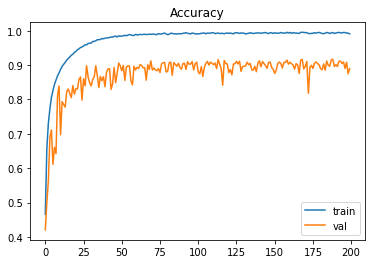

In [9]:
plt.plot(save_acc['train'])
plt.plot(save_acc['val'])
plt.legend(["train", "val"])
plt.title("Accuracy")


In [10]:
print(max(save_acc['val']),min(save_loss['val']))

tensor(0.9169, device='cuda:0') 0.36108125419430437


Text(0.5, 1.0, 'Loss')

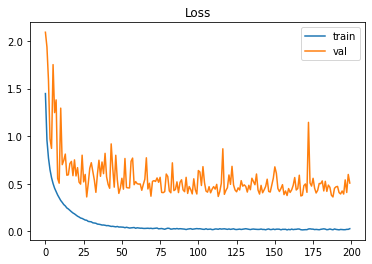

In [11]:
plt.plot(save_loss['train'])
plt.plot(save_loss['val'])
plt.legend(["train", "val"])
plt.title("Loss")

In [12]:
# save resnet model
PATH = './project1_model.pt'
torch.save(model.state_dict(), PATH)